#  Shakespear Poem generation with Predicting the next word

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

For this project we will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [4]:
!pip install gdown==5.1.0


[notice] A new release of pip is available: 23.1.2 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

C:\Users\ASUS\anaconda3\lib\site-packages\gdown\__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: C:\Users\ASUS\OneDrive\Bureau\ML Note book env\Shakespear poem generator\sonnets.txt

  0%|          | 0.00/93.6k [00:00<?, ?B/s]
100%|##########| 93.6k/93.6k [00:00<00:00, 124kB/s]
100%|##########| 93.6k/93.6k [00:00<00:00, 124kB/s]


In [6]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
    print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text

Now we fit the Tokenizer to the corpus and save the total number of words.


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

When converting the text into sequences we can use the texts_to_sequences method .

In the next  function we will need to process this corpus one line at a time. Given this, it is important to keep in mind that the way we are feeding the data unto this method affects the result. Check the following example to make this clearer.

The first example of the corpus is a string and looks like this:


In [8]:
corpus[0]

'from fairest creatures we desire increase,'

If we pass this text directly into the `texts_to_sequences` method we will get an unexpected result:

In [9]:
tokenizer.texts_to_sequences(corpus[0])

[[],
 [],
 [58],
 [],
 [],
 [],
 [17],
 [6],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 []]

This happened because `texts_to_sequences` expects a list and we are providing a string. However a string is still and `iterable` in Python so we will get the word index of every character in the string.

Instead we need to place the example whithin a list before passing it to the method:

In [10]:
tokenizer.texts_to_sequences([corpus[0]])
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

## Generating n_grams

Now we complete the `n_gram_seqs` function below. This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the `n_gram` sequences for each line in the corpus:

In [11]:
def n_gram_seqs(corpus, tokenizer):
    input_sequences = []

    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    return input_sequences

In [12]:
# Test the function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [13]:
# Test the function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

Apply the n_gram_seqs transformation to the whole corpus and save the maximum sequence length to use it later:


In [14]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add padding to the sequences

Now we code the `pad_seqs` function which will pad any given sequences to the desired maximum length. 

In [15]:
def pad_seqs(input_sequences, maxlen):
    padded_sequences = np.array(pad_sequences(input_sequences, maxlen=maxlen, padding='pre'))

    return padded_sequences

In [16]:
# Test the function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]])

In [17]:
# Test the function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]])

In [21]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Split the data into features and labels

Before feeding the data into the neural network we should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

This function expects the padded n_gram sequences as input and should return a tuple containing the features and the one hot encoded labels.

Notice that the function also receives the total of words in the corpus, this parameter will be very important when one hot enconding the labels since every word in the corpus will be a label at least once.


In [22]:
def features_and_labels(input_sequences, total_words):  
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels =  to_categorical(labels, num_classes=total_words)
    

    return features, one_hot_labels

In [23]:
# Test the function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]])

In [24]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Create the model

Now we should define a model architecture capable of achieving an accuracy of at least 80%.

model architecture

- An appropriate `output_dim` for the first layer (Embedding) is 100.
- A Bidirectional LSTM is helpful for this particular problem.
- The last layer should have the same number of units as the total number of words in the corpus and a softmax activation function.
- This problem can be solved with only two layers (excluding the Embedding) .

In [45]:
def create_model(total_words, max_sequence_len):
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
    model.add(Bidirectional(LSTM(80)))
    model.add(Dense(total_words, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


    return model

In [46]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 9s 13ms/step - loss: 6.9027 - accuracy: 0.0235
Epoch 2/50
484/484 [==============================] - 6s 13ms/step - loss: 6.4499 - accuracy: 0.0294
Epoch 3/50
484/484 [==============================] - 6s 12ms/step - loss: 6.2381 - accuracy: 0.0397
Epoch 4/50
484/484 [==============================] - 6s 12ms/step - loss: 6.0313 - accuracy: 0.0464
Epoch 5/50
484/484 [==============================] - 6s 12ms/step - loss: 5.8133 - accuracy: 0.0550
Epoch 6/50
484/484 [==============================] - 6s 12ms/step - loss: 5.5777 - accuracy: 0.0636
Epoch 7/50
484/484 [==============================] - 6s 12ms/step - loss: 5.3279 - accuracy: 0.0748
Epoch 8/50
484/484 [==============================] - 6s 12ms/step - loss: 5.0695 - accuracy: 0.0869
Epoch 9/50
484/484 [==============================] - 6s 12ms/step - loss: 4.8165 - accuracy: 0.1031
Epoch 10/50
484/484 [==============================] - 6s 12ms/step - loss: 4.5697 - accura

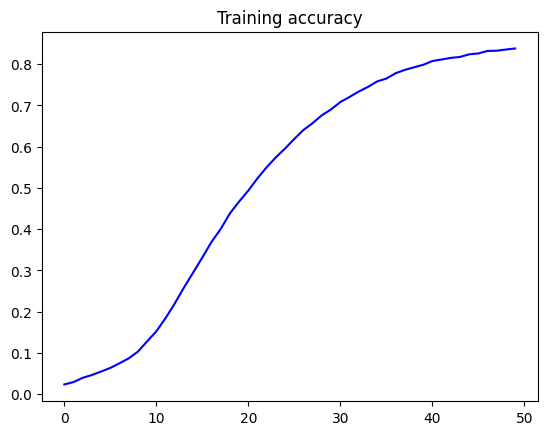

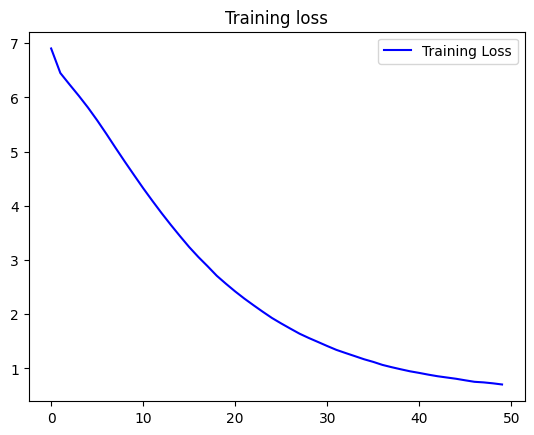

In [47]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [48]:
model.save("model/shakespear_generator.h5")

In [51]:

def generate_poem(seed_text,model=model, next_words=100):
    for _ in range(next_words):
        # Convert the text into sequences
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad the sequences
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Get the probabilities of predicting a word
        predicted = model.predict(token_list, verbose=0)
        # Choose the next word based on the maximum probability
        predicted = np.argmax(predicted, axis=-1).item()
        # Get the actual word from the word index
        output_word = tokenizer.index_word[predicted]
        # Append to the current text
        seed_text += " " + output_word
    return seed_text

print(generate_poem("Shall I compare thee to a summer's day"))

Shall I compare thee to a summer's day to me new friend the centre something glutton the very to common seem'd frown her to none none ear fond in thee the best winter's day sun on nature's boughs or night on perfection daily drop featureless breasts bequest dream are stand eisel doth such first is lie to any leisure on me now but alone lies bright again out o'er stol'n thy life ever be taken the grave was buried heart is light as kind and day doth first him gone on thy humour doth tell it fire i lie so happy did exceed none none grows near deceive


In [54]:
# Using the model from the .h5 file 
from tensorflow.keras.models import load_model
loaded_model = load_model("model/shakespear_generator.h5")
print(generate_poem("Rough winds do shake the darling buds of May", model=loaded_model))

Rough winds do shake the darling buds of May lie wind wind outworn held him born and you alone lie are so as as they fresh which hath left lose wood's night rarities men like of any eyes doth lie with me show'st blow very loving as no more knife note dumb wrack bequest bequest thievish told to perusal flow thank fond in state control it fire doth lie so born of mine one of thee one of thee be past your poor doth past sweet their virtue renew seem'd the shore mask'd clear it to show my seeing ' thee the dumb of thought was thorns of thine
